# Recommendation System

## Introduction

The data set used in this project is from the UCI Machine Learning Repository and it's a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
https://archive.ics.uci.edu/dataset/352/online+retail

## Context

At a broad level, Recommender systems employ two distinct strategies, or a combination of both, to suggest content to users.

1. **Collaborative Filtering:**
   Collaborative Filtering algorithms rely on usage data, encompassing both explicit and implicit feedback from users. These systems analyze patterns in user behavior, such as product purchases or preferences, to make recommendations. In essence, collaborative filtering identifies similarities between users or items to suggest content based on the preferences of similar users.

2. **Content-based Filtering:**
   Content-based Filtering algorithms utilize content metadata and user profiles to generate recommendations. This approach involves profiling items based on their characteristics, such as genre, IMDb ratings, box-office sales, etc. Simultaneously, users are profiled based on demographic information or responses to onboarding surveys. Content-based filtering recommends items that align with a user's preferences derived from their profile.

It's important to note that collaborative filtering thrives on substantial user feedback to function effectively, while content-based filtering relies heavily on detailed and accurate item descriptions to provide meaningful recommendations. These two approaches offer distinct perspectives, and their hybridization is often employed to enhance recommendation systems' accuracy and coverage.

In this project, we will be using the Collaborative Filtering approach to build a recommendation system for implicit feedback data (i.e. user transactions and purchase history).

Implicit user feedback encompasses a diverse range of interactions, including but not limited to browsing activity, search patterns, impressions, clicks, and even mouse movements. In contrast to explicit feedback, where users provide a clear indication of their preference degree for an item, implicit feedback lacks the same symmetry. Various factors can influence implicit feedback, making it a nuanced source of information.

Consider the scenario where a user might not engage with a book. This lack of engagement could be due to disliking the book, unawareness of its existence, unavailability in their region, or the book's prohibitive cost. Unlike explicit feedback, implicit signals don't explicitly convey the reason behind user behavior, leading to potential ambiguity.

One challenge in relying solely on implicit signals is the risk of bias towards positive interactions. By focusing predominantly on gathered positive signals, we may overlook valuable negative feedback. Addressing missing data becomes crucial as negative feedback might be present but not explicitly expressed. Unfortunately, this shift may result in a denser matrix, eliminating the sparsity that often allows for efficient algorithmic optimizations.

Implicit feedback introduces inherent noise into the system. For instance, a user may have purchased an item as a gift, watched a movie in a theater but slept through it, or missed a TV show due to a simultaneous live sports event. These complexities highlight the need for careful consideration and nuanced interpretation when working with implicit feedback, as it introduces uncertainties that explicit feedback might not encompass.



# Install required libraries

In [ ]:
%pip install -r requirements.txt

## Libraries



In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.sparse import coo_matrix

from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import *

warnings.filterwarnings('ignore')

We will set a Random Seed for reproducibility.

In [2]:
RANDOM_SEED = 1234

Let's load the data set and take a look at the first rows.

In [3]:
df = pd.read_excel('Online Retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


It's a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

## Data Cleaning

We will remove the rows that contain "credit" transactions, since we are only interested in the purchases. Moreover, we will remove the rows that contain missing values as well as the rows that have `POSTAGE` as the description.

In [4]:
df = df[~df['InvoiceNo'].str.startswith('C', na=False)] # removed credit transactions
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.dropna(inplace=True) # removed rows with missing values

In [6]:
df = df[~df['Description'].str.contains('POSTAGE')]
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Now let's see if we have any null values.

In [7]:
df[df['CustomerID'] == 'nan']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Good, we can now change data types for our attributes.

In [9]:
df = df.astype({
    'InvoiceNo': 'int32',
    'StockCode': 'str',
    'Description': 'str',
    'Quantity': 'int32',
    'InvoiceDate': 'datetime64[ns]',
    'UnitPrice': 'float32',
    'CustomerID': 'int32',
    'Country': 'str'
}, copy=True)

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Store the mappings of the CustomerID and StockCode for later use.

In [11]:
unique_customers = df['CustomerID'].unique()
customer_ids = dict(zip(unique_customers, np.arange(unique_customers.shape[0])))

unique_items = df['StockCode'].unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0])))

In [12]:
user_item_df = df.groupby(['CustomerID', 'StockCode', 'Description'])['Quantity'].sum().reset_index()

user_item_df.head()

,CustomerID,StockCode,Description,Quantity
0,12346,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
1,12347,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24
2,12347,17021,NAMASTE SWAGAT INCENSE,36
3,12347,20665,RED RETROSPOT PURSE,6
4,12347,20719,WOODLAND CHARLOTTE BAG,40


In [13]:
user_item_df['customer_id'] = user_item_df['CustomerID'].apply(lambda x: customer_ids[x])
user_item_df['item_id'] = user_item_df['StockCode'].apply(lambda x: item_ids[x])

In [14]:
item_customer = csr_matrix((user_item_df['Quantity'].astype(float), (user_item_df['item_id'], user_item_df['customer_id'])))
customer_item = csr_matrix((user_item_df['Quantity'].astype(float), (user_item_df['customer_id'], user_item_df['item_id'])))

# Collaborative filtering

Collaborative filtering is a technique used in recommender systems to make predictions or recommendations based on the preferences or behavior of similar users. It assumes that users who have similar preferences in the past will have similar preferences in the future.

The user-item matrix, also known as the utility matrix, is a fundamental concept in collaborative filtering. It represents the interactions between users and items in a matrix format. Each row in the matrix corresponds to a user, and each column corresponds to an item. The entries in the matrix represent the user's interaction or preference for a particular item.

For example, let's say we have a user-item matrix for a movie recommendation system. Each row represents a user, and each column represents a movie. The entries in the matrix could be ratings given by users to movies they have watched. If a user has not rated a particular movie, the entry in the matrix will be empty or zero.

Here's an example of a user-item matrix:



In [15]:
#        Movie A   Movie B   Movie C   Movie D
#User 1    5         4         0         3
#User 2    0         2         4         0
#User 3    3         0         0         1



In this matrix, User 1 has rated Movie A with a rating of 5, Movie B with a rating of 4, and so on. User 2 has not rated Movie A and Movie D, so the entries for those movies are zero or empty.

The user-item matrix is used as the basis for collaborative filtering algorithms. These algorithms analyze the patterns and relationships in the matrix to make recommendations. They can identify similar users based on their preferences and recommend items that have been positively rated by those similar users but have not been seen or rated by the target user.

By leveraging the user-item matrix and collaborative filtering techniques, recommender systems can provide personalized recommendations to users based on their similarities with other users.

Collaborative filtering, utilizes either neighborhood-based or latent factor models.

**Neighborhood Models:**
Neighborhood models, including clustering or top-N approaches, operate by identifying the closest users or items to generate recommendations. However, when dealing with implicit data, these models may struggle to differentiate between user preferences and the confidence associated with those preferences. Implicit feedback, such as purchase history or browsing patterns, lacks explicit indications of user preferences, introducing complexities in accurately gauging user intent.

**Factorization Models:**
On the other hand, factorization models aim to uncover latent features that explain observed ratings. This approach assumes a clear degree of user preference, where users explicitly rate or express their liking or disliking for items.

While factorization models have shown success with explicit feedback, adapting them to implicit feedback scenarios requires addressing the challenges of interpreting implicit signals. Implicit feedback introduces a layer of uncertainty, making it more challenging to discern the level of user preference accurately.

The first step in using this model is going to be transforming the quantity from the original dataset into values that can be used as confidences. We want to give to repeated buy of the same product more confidence in the model, but have this effect taper off as the number of repeated transactions increases to reduce the impact a single common product has on the model. Likewise we want to direct some of the confidence weight away from popular items. To do this we’ll use a `bm25`` weighting scheme inspired from classic information retrieval:

In [16]:
item_customer_weights = bm25_weight(item_customer, K1=100, B=0.8)
item_customer_weights = item_customer_weights.astype('double')
item_customer_weights

<3663x4339 sparse matrix of type '<class 'numpy.float64'>'
	with 266470 stored elements in COOrdinate format>

As we can see, now we have a matrix of the same dimensions as the original one, but with values that represent the confidence of the user-item interaction.

The two hyperparameters `K1` and `B` control the strength of the confidence. `K1` change the shape to go between the step function used in the Jaccard distance (K1 = 0) and the linear weighting used in the Cosine distance (K1 = +infinity). `B` controls the impact of the document frequency, with higher values giving less weight to common items.

We can now split the data into train and test sets. We will use the train set to train the model and the test set to evaluate it.

In [17]:
train, test = train_test_split(
    item_customer_weights.T, train_percentage=0.8, random_state=RANDOM_SEED)
train = train.astype('double')
test = test.astype('double')
train, test

(<4339x3663 sparse matrix of type '<class 'numpy.float64'>'
 	with 212982 stored elements in Compressed Sparse Row format>,
 <4339x3663 sparse matrix of type '<class 'numpy.float64'>'
 	with 53488 stored elements in Compressed Sparse Row format>)

Let's define a grid to find the best hyperparameters for our model.

In [18]:
from sklearn.model_selection import ParameterGrid

In [19]:
param_grid = {
    'factors': [64, 128, 256],
    'regularization': np.arange(0.05, 0.15, 0.05),
    'iterations': np.arange(50, 60, 10),
    'random_state': [RANDOM_SEED],
}

param_grid = ParameterGrid(param_grid)

Iterate over the grid and fit the model.

In [20]:
results = pd.DataFrame(columns=['factors', 'regularization',
                       'iterations', 'alpha', 'K', 'precision', 'map', 'ndcg', 'auc'])


for params in param_grid:
    model = AlternatingLeastSquares(**params)
    model.fit(train)

    metrics = ranking_metrics_at_k(model, train, test, K=10)
    metrics['K'] = 10
    metrics.update(params)
    results.loc[len(results)] = metrics

  2%|▏         | 1/50 [00:00<00:27,  1.75it/s]

100%|██████████| 4078/4078 [00:01<00:00, 3215.05it/s]


In [21]:
results.sort_values('auc', ascending=False).head(10)

,factors,regularization,iterations,alpha,K,precision,map,ndcg,auc
4,256,0.05,50,NaN,10,0.229666,0.136963,0.233339,0.595821
5,256,0.10,50,NaN,10,0.228649,0.136492,0.232544,0.595683
2,128,0.05,50,NaN,10,0.205882,0.115649,0.204661,0.587700
3,128,0.10,50,NaN,10,0.204648,0.115785,0.204403,0.587322
0,64,0.05,50,NaN,10,0.165650,0.086563,0.162072,0.572868
1,64,0.10,50,NaN,10,0.164779,0.086572,0.161981,0.572682


200 factors, regularization of 0.05 and 50 iterations seems to be the best combination.

In [22]:
model = AlternatingLeastSquares(factors=256, regularization=0.1, iterations=50, random_state=RANDOM_SEED, calculate_training_loss=True)

model.fit(train)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it, loss=0.0148]


Ranking metrics to evaluate the model.

In [23]:
ranking_metrics_at_k(model, train, test, K=10)

100%|██████████| 4078/4078 [00:01<00:00, 3320.44it/s]


{'precision': 0.2286492374727669,
 'map': 0.13649232797900027,
 'ndcg': 0.2325443143934244,
 'auc': 0.5956827641645792}

We can also save the model for later use.

In [60]:
if not os.path.exists('als_model'):
    model.save('als_model')
else:
    model.load('als_model')

Finding similar items to a given item

In [25]:
user_item_df.head()

,CustomerID,StockCode,Description,Quantity,customer_id,item_id
0,12346,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1104,2548
1,12347,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,409,1968
2,12347,17021,NAMASTE SWAGAT INCENSE,36,409,449
3,12347,20665,RED RETROSPOT PURSE,6,409,1227
4,12347,20719,WOODLAND CHARLOTTE BAG,40,409,1220


In [26]:
user_item_df.loc[user_item_df['item_id'] == 0].head()

,CustomerID,StockCode,Description,Quantity,customer_id,item_id
1328,12370,85123A,WHITE HANGING HEART T-LIGHT HOLDER,94,696,0
2258,12391,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10,4179,0
3052,12409,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2807,0
4376,12428,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1685,0
6070,12455,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,1495,0


Find the 10 most similar items to "WHITE HANGING HEART T-LIGHT HOLDER".

In [27]:
selected_item_id = 0
ids, scores = model.similar_items(
    selected_item_id, N=10, filter_items=[selected_item_id])
pd.DataFrame({'item_id': [user_item_df.loc[user_item_df['item_id'] == id]['Description'].unique()[0] for id in ids], 'score': scores})

,item_id,score
0,RED HANGING HEART T-LIGHT HOLDER,0.599304
1,CANDLEHOLDER PINK HANGING HEART,0.572219
2,CREAM HEART CARD HOLDER,0.345529
3,TEA TIME TEA TOWELS,0.276319
4,GLASS STAR FROSTED T-LIGHT HOLDER,0.222609
5,DOTCOMGIFTSHOP TEA TOWEL,0.217539
6,PINK SPOTS CHOCOLATE NESTING BOXES,0.200790
7,FAIRY SOAP SOAP HOLDER,0.199700
8,DIAMANTE NECKLACE GREEN,0.198563
9,DIAMANTE NECKLACE,0.198561


In [28]:
user_item_df.loc[user_item_df['customer_id'] == 0].head()

,CustomerID,StockCode,Description,Quantity,customer_id,item_id
251895,17850,15056BL,EDWARDIAN PARASOL BLACK,24,0,102
251896,17850,20679,EDWARDIAN PARASOL RED,42,0,46
251897,17850,21068,VINTAGE BILLBOARD LOVE/HATE MUG,96,0,50
251898,17850,21071,VINTAGE BILLBOARD DRINK ME MUG,96,0,49
251899,17850,21730,GLASS STAR FROSTED T-LIGHT HOLDER,104,0,6


Find the 10 most similar users to user 17850.

In [29]:
selected_user_id = 0
ids, scores = model.similar_users(
    selected_user_id, N=10, filter_users=[selected_user_id])
pd.DataFrame({'user_id': [list(customer_ids)[id]
             for id in ids], 'score': scores})

,user_id,score
0,12789,0.500353
1,17443,0.428349
2,12917,0.415954
3,14051,0.359900
4,16565,0.333561
5,13187,0.325841
6,16690,0.318948
7,13298,0.313484
8,12601,0.307875
9,13551,0.303187


Explanation of why an item is liked by a specific user

In [30]:
user_item_df.loc[user_item_df['customer_id'] == 0].sort_values('Quantity', ascending=False).head(10)

,CustomerID,StockCode,Description,Quantity,customer_id,item_id
251915,17850,85123A,WHITE HANGING HEART T-LIGHT HOLDER,122,0,0
251907,17850,71053,WHITE METAL LANTERN,122,0,1
251913,17850,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,110,0,3
251902,17850,22632,HAND WARMER RED POLKA DOT,108,0,8
251903,17850,22633,HAND WARMER UNION JACK,108,0,7
251914,17850,84406B,CREAM CUPID HEARTS COAT HANGER,108,0,2
251899,17850,21730,GLASS STAR FROSTED T-LIGHT HOLDER,104,0,6
251912,17850,84029E,RED WOOLLY HOTTIE WHITE HEART.,104,0,4
251898,17850,21071,VINTAGE BILLBOARD DRINK ME MUG,96,0,49
251906,17850,37370,RETRO COFFEE MUGS ASSORTED,96,0,47


In [32]:
#model = model.to_cpu()

total_score, top_contributions, user_weights = model.explain(userid=0, itemid=0, user_items=test)

Total predicted score for the pair (user_id, item_id) with CustomerID = 17850 (customer_id = 0) and StockCode = 85123A (item_id = 0).

In [33]:
total_score

0.9775827259068807

A list of the top N (itemid, score) contributions for this user/item pair

In [34]:
# Convert the list of (itemid, score) tuples into a dataframe with also the description
ids, scores = zip(*top_contributions)
pd.DataFrame({'item_id': [user_item_df.loc[user_item_df['item_id'] == id]
             ['Description'].unique()[0] for id in ids], 'score': scores})

,item_id,score
0,WHITE HANGING HEART T-LIGHT HOLDER,0.893608
1,GLASS STAR FROSTED T-LIGHT HOLDER,0.044842
2,RED WOOLLY HOTTIE WHITE HEART.,0.014364
3,CREAM CUPID HEARTS COAT HANGER,0.009718
4,3 DRAWER ANTIQUE WHITE WOOD CABINET,0.005586
5,EDWARDIAN PARASOL RED,0.005458
6,HAND WARMER UNION JACK,0.004006


So basically the recommendation system is telling us that the reason why there was a suggestion for the item `RED HANGING HEART T-LIGHT HOLDER` was because the user `17850` bought the item `WHITE HANGING HEART T-LIGHT HOLDER` and the item `WHITE HANGING HEART T-LIGHT HOLDER` is similar to the item `RED HANGING HEART T-LIGHT HOLDER`. This is highlighted by the fact that the score of contribution of the item `WHITE HANGING HEART T-LIGHT HOLDER` is the highest.

Then we can also recommend general items for a given user.

In [36]:
ids, scores = model.recommend(0, user_items=test[0], N=10, filter_already_liked_items=True)
pd.DataFrame({'item_id': [user_item_df.loc[user_item_df['item_id'] == id]['Description'].unique()[0] for id in ids], 'score': scores})

,item_id,score
0,WOODEN FRAME ANTIQUE WHITE,1.003639
1,WHITE METAL LANTERN,0.999102
2,VINTAGE BILLBOARD DRINK ME MUG,0.996417
3,VINTAGE BILLBOARD LOVE/HATE MUG,0.993105
4,KNITTED UNION FLAG HOT WATER BOTTLE,0.992531
5,WOOD 2 DRAWER CABINET WHITE FINISH,0.992488
6,HAND WARMER RED RETROSPOT,0.989699
7,WOODEN PICTURE FRAME WHITE FINISH,0.987895
8,RETRO COFFEE MUGS ASSORTED,0.987404
9,SET 7 BABUSHKA NESTING BOXES,0.986911


If we want to see how our model performs on the test set, we can plot the ranking metrics for increasing value of K, which is the number of items to recommend.

In [47]:
metrics_eval_df = pd.DataFrame(columns=['K', 'precision', 'map', 'ndcg', 'auc'])

for k in np.arange(5, 55, 5):
    metrics = ranking_metrics_at_k(model, train, test, K=k)
    metrics['K'] = k
    metrics_eval_df.loc[len(metrics_eval_df)] = metrics

100%|██████████| 4078/4078 [00:01<00:00, 2834.51it/s]


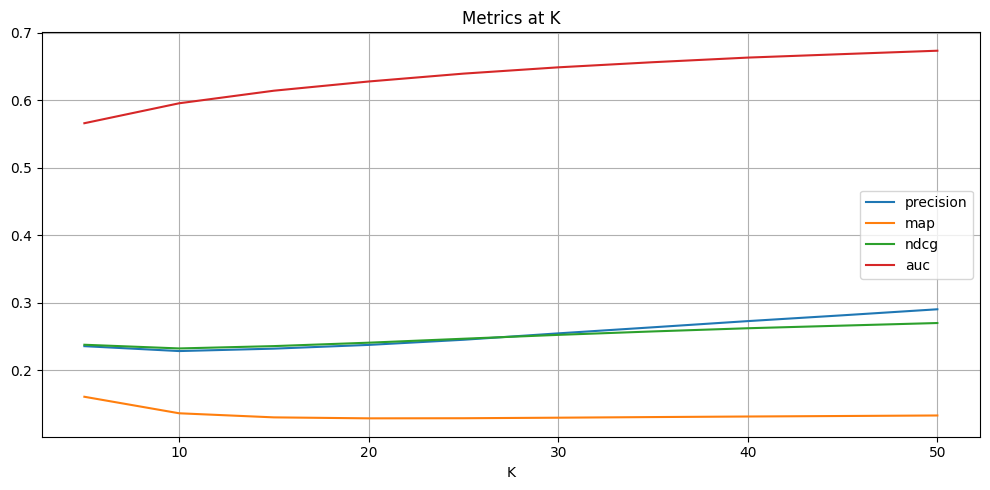

In [57]:
metrics_eval_df.plot(x='K', y=['precision', 'map', 'ndcg', 'auc'], figsize=(10, 5), title='Metrics at K', grid=True)
plt.tight_layout()
plt.show()

In conclusion, the interpretation of results in recommendation systems can be somewhat complex. This complexity arises from the inherent nature of these systems, which often involve intricate algorithms and large datasets. 

To address this challenge, we divided our data into training and testing sets. This approach allowed us to evaluate the performance of our recommendation system on unseen data, providing a more robust and reliable measure of its effectiveness. Specifically, we were able to assess whether items in the test set would indeed be recommended to the corresponding user.

Our analysis revealed several key trends. Firstly, the Area Under the Curve (AUC) at `k` increased as we expanded the number of items included in the suggestions. While this may seem trivial, it is a crucial aspect of recommendation systems, demonstrating their ability to effectively rank a larger pool of items.

Secondly, we observed that both the Normalized Discounted Cumulative Gain (NDCG) at `k` and Precision at `k` followed the same trend. This similarity is significant as both these metrics are critical for evaluating the quality of our recommendations.

Finally, we also examined the Mean Average Precision (MAP) at `k`, another important metric in recommendation systems. MAP@k provides a single-figure measure of quality across recall levels, making it a valuable tool for comparing different recommendation approaches.

In summary, while interpreting results in recommendation systems can be challenging, careful methodological choices and rigorous evaluation can provide valuable insights into their performance and effectiveness. By leveraging various metrics and testing on unseen data, we can ensure that our recommendation system is not only robust and reliable but also capable of delivering high-quality recommendations.